In [1]:
import os
import yaml
import pickle
import argparse
import importlib
import numpy as np
import torch
from tqdm import tqdm
from argparse import ArgumentParser
import torch
import torchvision
from torch.nn.parallel import DistributedDataParallel
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import sys
sys.path.append('/input0')
import os
os.chdir("..")
from CasMVSNet_pl.models.mvsnet import CascadeMVSNet
from CasMVSNet_pl.models.mvsnet import CascadeMVSNet
from CasMVSNet_pl.utils import load_ckpt
from CasMVSNet_pl.utils import * 

from torchvision import transforms as T
import matplotlib.pyplot as plt
from inplace_abn import ABN
import os
from debug_utils import DTUDataset, PanoOutpaintGenerator ,DTU

/input0


/openbayes/input/input0/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def decode_batch(batch):
    imgs = batch['images']
    proj_mats = batch['proj_mats']
    depths = batch['depths']
    masks = batch['masks']
    init_depth_min = batch['init_depth_min'].item()
    depth_interval = batch['depth_interval'].item()
    return imgs, proj_mats, init_depth_min, depth_interval

unpreprocess = T.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], 
                           std=[1/0.229, 1/0.224, 1/0.225])

In [72]:
def visualize_depth(x, cmap=cv2.COLORMAP_JET):
        """
        depth: (H, W)
        """
        
        x = x.cpu().detach().numpy()
        x = np.nan_to_num(x) # change nan to 0
        mi = np.min(x[x>0]) # get minimum positive depth (ignore background)
        ma = np.max(x)
        x = (x-mi)/(ma-mi+1e-8) # normalize to 0~1
        x = (255*x).astype(np.uint8)
        x_ = Image.fromarray(cv2.applyColorMap(x, cmap))
        x_ = T.ToTensor()(x_) # (3, H, W)
        return x_
def normalize_depth(x):
        
        x = torch.nan_to_num(x) # change nan to 0
        mi = torch.min(x[x>0]) # get minimum positive depth (ignore background)
        ma = torch.max(x)
        x = (x-mi)/(ma-mi+1e-8) # normalize to 0~1
        x = (255*x)
       
        return x


In [4]:
depth_model = CascadeMVSNet(n_depths=[8,32,48],
                      interval_ratios=[1.0,2.0,4.0],
                      num_groups=1,
                      norm_act=ABN).cuda()
load_ckpt(depth_model, '/openbayes/input/input0/CasMVSNet_pl/ckpts/_ckpt_epoch_10.ckpt')
depth_model.eval()

CascadeMVSNet(
  (feature): FeatureNet(
    (conv0): Sequential(
      (0): ConvBnReLU(
        (conv): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): ABN(8, eps=1e-05, momentum=0.1, affine=True, activation=leaky_relu[0.01])
      )
      (1): ConvBnReLU(
        (conv): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): ABN(8, eps=1e-05, momentum=0.1, affine=True, activation=leaky_relu[0.01])
      )
    )
    (conv1): Sequential(
      (0): ConvBnReLU(
        (conv): Conv2d(8, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
        (bn): ABN(16, eps=1e-05, momentum=0.1, affine=True, activation=leaky_relu[0.01])
      )
      (1): ConvBnReLU(
        (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): ABN(16, eps=1e-05, momentum=0.1, affine=True, activation=leaky_relu[0.01])
      )
      (2): ConvBnReLU(
        (conv): Conv2d(16, 16, k

In [76]:
def plot_depths(batch,results,depths,path = "./"):
    
    fig, axs = plt.subplots(4, 3, figsize=(10, 10))
    gt_result,impaired_result,pred_result = results
    depth_pred =  pred_result["depth_0"]
    depth_gt =  gt_result["depth_0"]
    depth_impaired =  impaired_result["depth_0"]
    
    images,mask_images,images_pred = batch


    axs[0,0].imshow(visualize_depth(gt_result['depth_0'][0]).permute(1,2,0))
    axs[0,0].set_title("gt_depth")
    axs[0,1].imshow(visualize_depth(pred_result['depth_0'][0]).permute(1,2,0))
    axs[0,1].set_title("predicted_depth")
    axs[0,2].imshow(visualize_depth( depth_impaired[0]).permute(1,2,0))
    axs[0,2].set_title("impaired_depth")

    #unpreprocess = normalize_depth
        
    axs[1,0].imshow(unpreprocess(images[0][0]).permute(1,2,0))
    axs[1,0].set_title("image 1")
    axs[1,1].imshow(unpreprocess(images[0][1]).permute(1,2,0))
    axs[1,1].set_title("image 2")
    axs[1,2].imshow(unpreprocess(images[0][2]).permute(1,2,0))
    axs[1,2].set_title("image 3")
    axs[2,0].imshow(unpreprocess(mask_images[0][0]).permute(1,2,0).cpu().detach().numpy())
    axs[2,0].set_title("mask image 1")
    axs[2,1].imshow(unpreprocess(mask_images[0][1]).permute(1,2,0).cpu().detach().numpy())
    axs[2,1].set_title("mask image 2")
    axs[2,2].imshow(unpreprocess(mask_images[0][2]).permute(1,2,0).cpu().detach().numpy())
    axs[2,2].set_title("mask image 3")
    axs[3,0].imshow(unpreprocess(images_pred[0][0]).permute(1,2,0).cpu().detach().numpy())
    axs[3,0].set_title("predicted image 1")
    axs[3,1].imshow(unpreprocess(images_pred[0][1]).permute(1,2,0).cpu().detach().numpy())
    axs[3,1].set_title("predicted image 2")
    axs[3,2].imshow(unpreprocess(images_pred[0][2]).permute(1,2,0).cpu().detach().numpy())
    axs[3,2].set_title("predicted image 3")

    img_dir1 = os.path.join(path,"depths_prediction.png")
    img_dir2 = os.path.join(path,"observed_dephts.png")

    plt.savefig(img_dir1)
    plt.close()
    plt.imshow(visualize_depth(depths[0]).permute(1,2,0), alpha=0.5)
    
    plt.savefig(img_dir2)
    plt.close()
        
    
    

## define the model

In [127]:
class PanoOutpaint(PanoOutpaintGenerator):
    def __init__(self, depth_model,plot_depths,**kwargs):
        super().__init__( **kwargs)
        self.depth_model = depth_model
        self.plot_depths = plot_depths
    def decode_latent(self,latents,vae,transformation = False):
        b, m = latents.shape[0:2]
        latents = (1 / vae.config.scaling_factor * latents)

        images = []
        for j in range(m):
            image = vae.decode(latents[:, j]).sample
            images.append(image)
        image = torch.stack(images, dim=1)

        image = (image / 2 + 0.5).clamp(0, 1) # -1 ,1 
        #image = image.permute(0, 1, 3, 4, 2).float()#.cpu().numpy()
        #image = (image * 255)#.round().astype('uint8')
        if transformation:
            transformation =  T.Compose([T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
            image = transformation(image)
            print("transformed image shape is:",image.shape)
        return image
    def training_step(self,batch,batch_idx):
        depth_model=self.depth_model
        plot_depths=self.plot_depths
        images = batch["images"]
        mask_images = batch["dark_imgs"].cuda()

        bs, m, _,h, w = images.shape
        #images=rearrange(images, 'bs m h w c -> bs m c h w')
        #mask_images=rearrange(mask_images, 'bs m h w c -> bs m c h w')
        #print(images.shape,mask_images.shape)
        
        mask_latnets, masked_image_latents=self.prepare_mask_image(mask_images,batch)
        

        device = mask_images.device

        latents= torch.randn(
            bs, m, 4, h//8, w//8, device=device)

        prompt_embds = []
        for prompt in batch['prompts']:
            prompt = prompt[0]
            print(prompt)
            prompt_embds.append(self.encode_text(
                prompt, device)[0])
        prompt_embds = torch.stack(prompt_embds, dim=1)

        prompt_null = self.encode_text('', device)[0]
        prompt_embd = torch.cat(
            [prompt_null[:, None].repeat(1, m, 1, 1), prompt_embds])

        self.scheduler.set_timesteps(self.diff_timestep, device=device)
        timesteps = self.scheduler.timesteps


        for i, t in enumerate(timesteps):
            _timestep = torch.cat([t[None, None]]*m, dim=1)
            #print(latents.shape,mask_latnets.shape,masked_image_latents.shape)
            latent_model_input = torch.cat([latents, mask_latnets, masked_image_latents], dim=2)

            noise_pred = self.forward_cls_free(
                latent_model_input, _timestep, prompt_embd, batch, self.mv_base_model)

            latents = self.scheduler.step(
                noise_pred, t, latents).prev_sample

        images_pred = self.decode_latent(
            latents, self.vae,transformation = True)
        
        print(images_pred.shape)
        images, proj_mats, init_depth_min, depth_interval = decode_batch(batch)
        gt_result = depth_model(images.cuda(), proj_mats.cuda(), init_depth_min, depth_interval)
        

        impaired_result = depth_model(mask_images.cuda(), proj_mats.cuda(), init_depth_min, depth_interval)
       

        pred_result = depth_model(images_pred, proj_mats.cuda(), init_depth_min, depth_interval)
        
        results = gt_result,impaired_result,pred_result
        
        batch_images = images,mask_images,images_pred 
        plot_depths(batch_images,results,batch["depths"])

        


        depth_pred =  pred_result["depth_0"]
        depth_gt =  gt_result["depth_0"]
        depth_impaired =  impaired_result["depth_0"]
        loss = torch.nn.functional.mse_loss(depth_pred,depth_gt)
        print("loss is : ",loss)

       

        return loss
    @torch.no_grad()
    def inference(self,batch):
        images = batch["dark_imgs"]
        mask_images = batch["dark_imgs"]

        bs, m, _,h, w = images.shape
        #images=rearrange(images, 'bs m h w c -> bs m c h w')
        #mask_images=rearrange(mask_images, 'bs m h w c -> bs m c h w')
        #print(images.shape,mask_images.shape)
        mask_latnets, masked_image_latents=self.prepare_mask_image(mask_images,batch)

        device = images.device

        latents= torch.randn(
            bs, m, 4, h//8, w//8, device=device)

        prompt_embds = []
        for prompt in batch['prompts']:
            prompt = prompt[0]
            print(prompt)
            prompt_embds.append(self.encode_text(
                prompt, device)[0])
        prompt_embds = torch.stack(prompt_embds, dim=1)

        prompt_null = self.encode_text('', device)[0]
        prompt_embd = torch.cat(
            [prompt_null[:, None].repeat(1, m, 1, 1), prompt_embds])

        self.scheduler.set_timesteps(self.diff_timestep, device=device)
        timesteps = self.scheduler.timesteps


        for i, t in enumerate(timesteps):
            _timestep = torch.cat([t[None, None]]*m, dim=1)
            #print(latents.shape,mask_latnets.shape,masked_image_latents.shape)
            latent_model_input = torch.cat([latents, mask_latnets, masked_image_latents], dim=2)

            noise_pred = self.forward_cls_free(
                latent_model_input, _timestep, prompt_embd, batch, self.mv_base_model)

            latents = self.scheduler.step(
                noise_pred, t, latents).prev_sample

        images_pred = self.decode_latent(
            latents, self.vae,transformation = True)
        return images_pred



    def validation_step(self, batch, batch_idx):
        
        depth_model=self.depth_model
        plot_depths=self.plot_depths
        images_pred = self.inference(batch)
        

        images = batch["images"]
        mask_images = batch["dark_imgs"].cuda()
        depths = batch["depths"]

        
        images, proj_mats, init_depth_min, depth_interval = decode_batch(batch)

        
        gt_result = depth_model(images.cuda(), proj_mats.cuda(), init_depth_min, depth_interval)
        

        impaired_result = depth_model(mask_images.cuda(), proj_mats.cuda(), init_depth_min, depth_interval)
       

        pred_result = depth_model(images_pred, proj_mats.cuda(), init_depth_min, depth_interval)
        
        results = gt_result,impaired_result,pred_result

        try:
            img_dir = os.path.join(self.logger.log_dir, 'images')
        except:
            
            img_dir = os.path.join("./", 'validation_step_images')

        
        batch_images = images,mask_images,images_pred 
        plot_depths(batch_images,results,depths,path=img_dir)
        images = ((batch['images']/2+0.5)
                          * 255).cpu().numpy().astype(np.uint8)
        images_pred = ((images_pred.permute(0,1,3,4,2)/2+0.5)
                          * 255).cpu().numpy().astype(np.uint8)
        plt.imshow(images_pred[0][0])
        plt.show()
        
        # compute image & save
        try:
            if self.trainer.global_rank == 0:
                self.save_image(images_pred, images, batch['prompt'], batch_idx)
        except:
            print("not bound to logger and trainer")

In [128]:
dataset = DTU(root_dir = "/openbayes/input/input0/dtu",split = "train",len = 1)
config = yaml.load(open("/openbayes/input/input0/test.yaml", 'rb'), Loader=yaml.SafeLoader)
model = PanoOutpaint(config = config,depth_model=depth_model,plot_depths=plot_depths)
model.load_state_dict(torch.load("/openbayes/input/input0/weights/pano_outpaint.ckpt",
                                 map_location='cpu')['state_dict'], strict=False)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
/openbayes/input/input0/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:198: Attribute 'depth_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['depth_model'])`.


_IncompatibleKeys(missing_keys=['vae.encoder.mid_block.attentions.0.to_q.weight', 'vae.encoder.mid_block.attentions.0.to_q.bias', 'vae.encoder.mid_block.attentions.0.to_k.weight', 'vae.encoder.mid_block.attentions.0.to_k.bias', 'vae.encoder.mid_block.attentions.0.to_v.weight', 'vae.encoder.mid_block.attentions.0.to_v.bias', 'vae.encoder.mid_block.attentions.0.to_out.0.weight', 'vae.encoder.mid_block.attentions.0.to_out.0.bias', 'vae.decoder.mid_block.attentions.0.to_q.weight', 'vae.decoder.mid_block.attentions.0.to_q.bias', 'vae.decoder.mid_block.attentions.0.to_k.weight', 'vae.decoder.mid_block.attentions.0.to_k.bias', 'vae.decoder.mid_block.attentions.0.to_v.weight', 'vae.decoder.mid_block.attentions.0.to_v.bias', 'vae.decoder.mid_block.attentions.0.to_out.0.weight', 'vae.decoder.mid_block.attentions.0.to_out.0.bias', 'depth_model.feature.conv0.0.conv.weight', 'depth_model.feature.conv0.0.bn.weight', 'depth_model.feature.conv0.0.bn.bias', 'depth_model.feature.conv0.0.bn.running_mean'

dict_keys(['init_depth_min', 'masks', 'depths', 'homographys', 'prompts', 'mask', 'dark_imgs', 'imgs', 'images', 'proj_mats', 'depth_interval', 'scan_vid', 'R', 'K', 'use_corres'])
a statue of a rabbit sitting on top of a box in van goth sytled
a statue of a rabbit sitting on top of a box in van goth sytled
a statue of a rabbit sitting on top of a box in van goth sytled
transformed image shape is: torch.Size([1, 3, 3, 512, 640])
torch.Size([1, 3, 3, 512, 640])
loss is :  tensor(1977.1979, device='cuda:0')
a statue of a rabbit sitting on top of a box in van goth sytled
a statue of a rabbit sitting on top of a box in van goth sytled
a statue of a rabbit sitting on top of a box in van goth sytled
transformed image shape is: torch.Size([1, 3, 3, 512, 640])


FileNotFoundError: [Errno 2] No such file or directory: '/openbayes/home/tf_dir/experiment_trainer/version_2/images/depths_prediction.png'

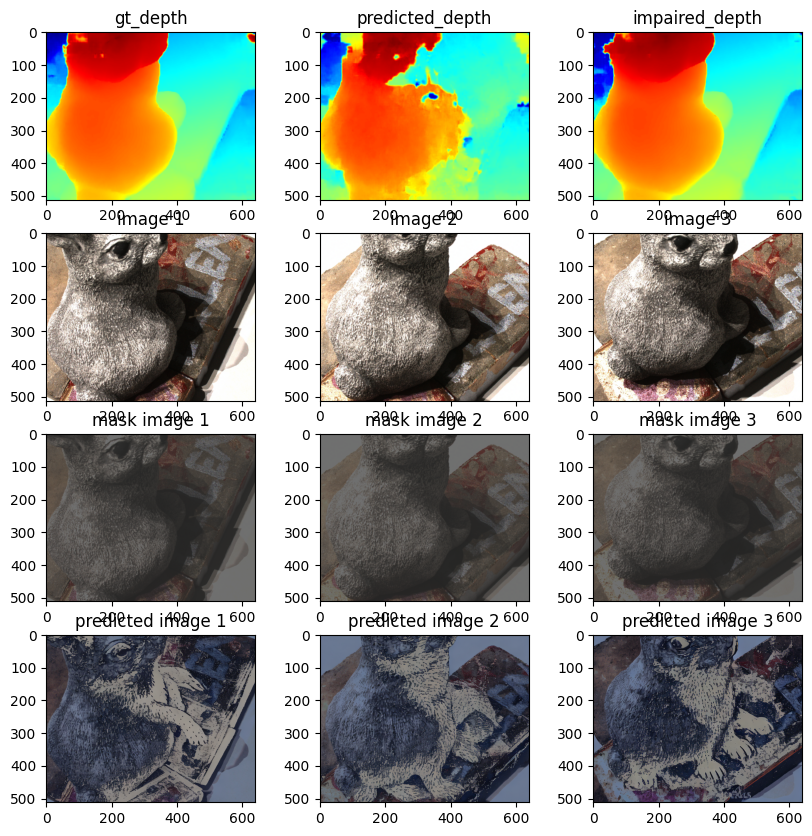

In [134]:
from torch.nn import MSELoss
from torch.utils.data import DataLoader
train_loader = DataLoader(dataset,batch_size = 1)
model = model.cuda()
for data in train_loader:
    data["dark_imgs"] =data["dark_imgs"].cuda()
    data["imgs"] = data["imgs"].cuda()
    data["R"] = data["R"].cuda()
    data["K"]= data["K"].cuda()
    data["use_corres"]=False
    data["homographys"] = data["homographys"].cuda().float()
    #data["images"] = data["dark_imgs"].cuda()
    print(data.keys())
    
    
    #image_pred = model.inference(data)
    
    #print(image_pred.shape)

    #plt.imshow(image_pred[0][0])
    #plt.show()



    #unprocess = T.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], 
        #                                std=[1/0.229, 1/0.224, 1/0.225])
    with torch.no_grad():
        
        loss = model.training_step(data,0)
        model.validation_step(data,0)
    '''
    plt.imshow(visualize_depth(result1['depth_0'][0]).permute(1,2,0), alpha=0.5)
    plt.show()
    plt.imshow(visualize_depth(result2['depth_0'][0]).permute(1,2,0), alpha=0.5)
    plt.show()
    plt.imshow(visualize_depth(data["depths"][0]).permute(1,2,0), alpha=0.5)
    plt.show()
    print(imgs.shape)
    plt.imshow(unpreprocess(imgs[0][1]).permute(1,2,0).cpu().detach().numpy(), alpha=0.5)
    plt.show()
    plt.imshow(unpreprocess(dark_imgs[0][0]).permute(1,2,0).cpu().detach().numpy(), alpha=0.5)
    '''

# start use pytorch_lightning to train model

In [135]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning import Trainer

In [136]:
args = argparse.Namespace(
    gpus=2,
    num_nodes=1,
    accelerator='ddp',
    max_epochs=100,
    log_every_n_steps=100,
    num_sanity_val_steps=1,
    limit_val_batches=1,
    benchmark=True,
    check_val_every_n_epoch=10,
)

In [141]:
checkpoint_callback = ModelCheckpoint(save_top_k=1, monitor="train_loss",
                                      mode="min", save_last=1,
                                      filename='epoch={epoch}-loss={train_loss:.4f}')

logger = TensorBoardLogger(
    save_dir='/openbayes/home/tf_dir', name="experiment_trainer", default_hp_metric=False)

# Create the trainer from args
trainer = pl.Trainer(
    devices=2,
    num_nodes=1,
    accelerator="cuda",
    max_epochs=args.max_epochs,
    log_every_n_steps=args.log_every_n_steps,
    num_sanity_val_steps=args.num_sanity_val_steps,
    limit_val_batches=args.limit_val_batches,
    benchmark=args.benchmark,
    check_val_every_n_epoch=args.check_val_every_n_epoch,
    callbacks=[checkpoint_callback],
    logger=logger
)

trainer.fit(model, train_loader, train_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_val_batches=1)` was configured so 1 batch will be used.


RuntimeError: Lightning can't create new processes if CUDA is already initialized. Did you manually call `torch.cuda.*` functions, have moved the model to the device, or allocated memory on the GPU any other way? Please remove any such calls, or change the selected strategy. You will have to restart the Python kernel.